In [51]:
# 1.1 Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [52]:
# 1.2 Load dataset
df = pd.read_csv('indonesian_movies.csv')

In [53]:
# 2.1 Preprocessing Data

## Drop duplicates data

df = df.drop_duplicates()

## Check Missing Value

df.isnull().sum()

# There are NaN data rows in the description, genre, rating, votes, director, and runtime columns.
# Drop Missing Value
# df = df.dropna(subset=['description', 'genre', 'rating', 'votes', 'directors', 'runtime'])

title             0
year              0
description     432
genre            36
rating          896
users_rating      0
votes             0
languages         0
directors         7
actors            0
runtime         403
dtype: int64

In [54]:
# 2.2 Data Transformation

# 2.2.1

df['runtime'] = df['runtime'].str.replace(' min', '')

df['actors'] = df['actors'].str.replace(', nan', '')

In [55]:
# 2.2.2 

df['year'] = df['year'].astype(int, errors='ignore')
df['votes'] = pd.to_numeric(df['votes'], errors='coerce')
df['users_rating'] = pd.to_numeric(df['users_rating'], errors='coerce')
df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')

In [56]:
# 2.2.3 Mapping runtime categories

def categorize_runtime(runtime):
    if runtime < 60:
        return '<60 minutes'
    elif 60 <= runtime < 70:
        return '60-70 minutes'
    elif 70 <= runtime < 80:
        return '70-80 minutes'
    elif 80 <= runtime < 90:
        return '80-90 minutes'
    elif 90 <= runtime < 100:
        return '90-100 minutes'
    elif 100 <= runtime < 110:
        return '100-110 minutes'
    elif 110 <= runtime < 120:
        return '110-120 minutes'
    else:
        return '>120 minutes'

df['runtime_category'] = df['runtime'].apply(categorize_runtime)

In [57]:
# 2.2.4 Mapping votes categories

def categorize_votes(votes):
    if votes < 100:
        return '<100'
    elif 100 <= votes < 200:
        return '100-200'
    elif 200 <= votes < 300:
        return '200-300'
    elif 300 <= votes < 400:
        return '300-400'
    elif 400 <= votes < 500:
        return '400-500'
    elif 500 <= votes < 600:
        return '500-600'
    elif 600 <= votes < 700:
        return '600-700'
    elif 700 <= votes < 800:
        return '700-800'
    elif 700 <= votes < 800:
        return '600-700'
    else:
        return '>900'

df['votes_category'] = df['votes'].apply(categorize_votes)

In [58]:
# 2.2.5 Mapping ages rating categories

rating_mapping = {
    '13+': 'R13+',
    'PG-13 rating': 'R13+',
    'TV-14': 'R13+',
    '17+': 'D17+',
    'R': 'D17+',
    'TV-MA': 'D17+',
    '21+': 'D21+',
    'D': 'D21+',
    'SU': 'SU',
    'Not Ranted': pd.NA,
    'Unrated': pd.NA
}

df['rating'] = df['rating'].map(rating_mapping)

## 3. Clustering berdasarkan fitur numerik (unsupervised):

In [59]:
# 3.1 Select and Clear Numeric Features

numerical_df = df[['users_rating', 'votes', 'runtime']].dropna()

In [60]:
# 3.2 Data Standardization

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_df)


In [61]:
numerical_df['votes'] = pd.to_numeric(numerical_df['votes'], errors='coerce')
numerical_df['users_rating'] = pd.to_numeric(numerical_df['users_rating'], errors='coerce')
numerical_df['runtime'] = pd.to_numeric(numerical_df['runtime'], errors='coerce')
numerical_df = numerical_df.dropna()


In [62]:
print(numerical_df.isnull().sum())
print(numerical_df.dtypes)


users_rating    0
votes           0
runtime         0
dtype: int64
users_rating    float64
votes           float64
runtime         float64
dtype: object


In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_df.values)


In [64]:
# 3.3 Specify Number of Clusters (Optional)

scaled_features = scaler.fit_transform(numerical_df)

# Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Jumlah Cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()


AttributeError: 'NoneType' object has no attribute 'split'

Initially we wanted to use the Elbow method to find the optimal number of clusters, but because an error occurred here, we assumed **k=3**.

In [65]:
# 3.4 Clustering

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# Tambahkan ke DataFrame asli
df.loc[numerical_df.index, 'cluster'] = cluster_labels


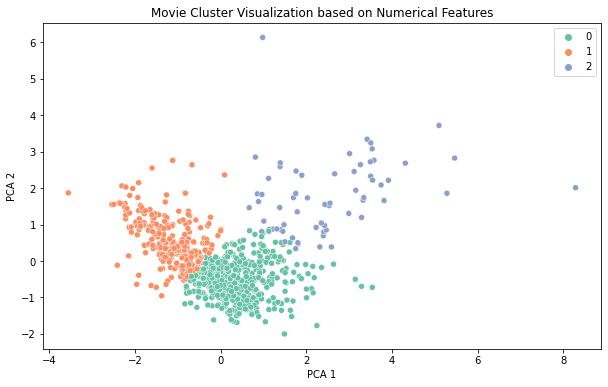

In [66]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

plt.figure(figsize=(10,6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=cluster_labels, palette='Set2')
plt.title('Movie Cluster Visualization based on Numerical Features')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


In [67]:
df.groupby('cluster')[['users_rating', 'votes', 'runtime']].mean()


,users_rating,votes,runtime
cluster,,,
0.0,6.930041,58.304527,100.104938
1.0,4.597552,33.968531,86.461538
2.0,6.631250,518.250000,112.828125


---

### **KClustering Based on Numeric Features**
(Features: `users_rating`, `votes`, `runtime`)

#### **Cluster Characteristics**:
1. **Cluster 0**
- **High rating** (~6.9)
- **Few votes** (~58)
- **Medium length** (~100 minutes)
- **Interpretation**: A film with good ratings but not very popular (possibly an independent or niche film).

2. **Cluster 1**
- **Low rating** (~4.6)
- **Few votes** (~34)
- **Short length** (~86 minutes)
- **Interpretation**: A film that is not well-liked and popular; possibly a low-quality film or with limited distribution.

3. **Cluster 2**
- **Quite high rating** (~6.6)
- **Very high votes** (~518)
- **Longest duration** (~113 minutes)
- **Interpretation**: Films that are **generally successful** and popular — may include box office or critical hits.

---

## 4. Clustering dengan Teks (deskripsi film)

No handles with labels found to put in legend.


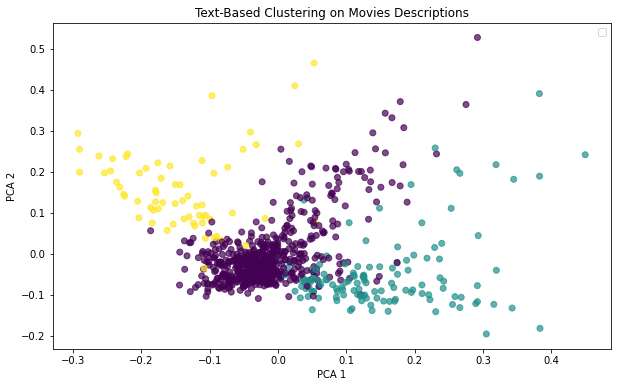

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 4.1 Preprocessing text
descriptions = df['description'].dropna()

# 4.2 TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf.fit_transform(descriptions)

# 4.3 KMeans Clustering
k = 3
kmeans_text = KMeans(n_clusters=k, random_state=42)
clusters = kmeans_text.fit_predict(tfidf_matrix)

# 4.4 Add clustering results to the original DataFrame
df.loc[descriptions.index, 'text_cluster'] = clusters

# 4.5 Visualization with PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(10,6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title("Text-Based Clustering on Movies Descriptions")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()


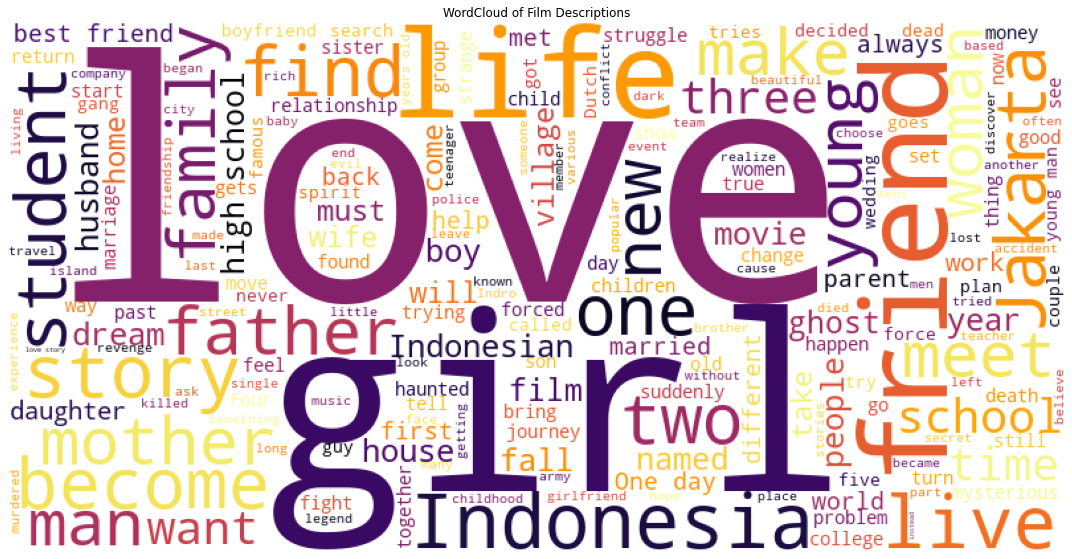

In [69]:
#

from wordcloud import WordCloud

text = " ".join(df['description'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='inferno').generate(text)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('WordCloud of Film Descriptions')
plt.tight_layout()
plt.show()

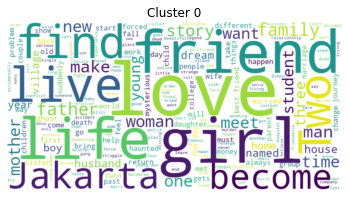

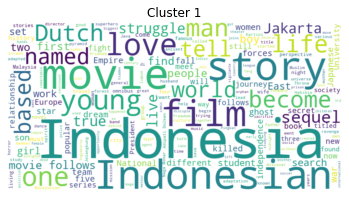

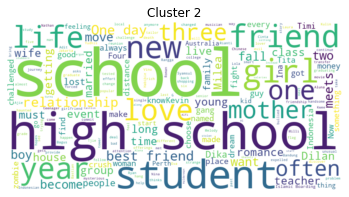

In [70]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for i in range(3):
    text = " ".join(df[df['text_cluster'] == i]['description'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Cluster {i}")
    plt.show()


In [72]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

text_df = df['description'].dropna()

# Misal data kamu
# df['description'] = deskripsi film
# df['text_cluster'] = label hasil clustering (misal dari KMeans)

# 1. TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf.fit_transform(text_df)

# 2. Buat DataFrame dari TF-IDF
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names())

# 3. Tambahkan kolom cluster
tfidf_df['cluster'] = df['text_cluster']

# 4. Hitung rata-rata skor TF-IDF tiap kata per cluster
tfidf_means = tfidf_df.groupby('cluster').mean()

# 5. Ambil Top-N kata tertinggi per cluster
top_n = 10
top_words_per_cluster = {}

for cluster_num in tfidf_means.index:
    top_words = tfidf_means.loc[cluster_num].sort_values(ascending=False).head(top_n)
    top_words_per_cluster[cluster_num] = top_words

# 6. Tampilkan hasil
for cluster, top_words in top_words_per_cluster.items():
    print(f"\n Top {top_n} kata untuk Cluster {cluster}:")
    print(top_words)



 Top 10 kata untuk Cluster 0.0:
love          0.021272
story         0.013796
friends       0.013711
girl          0.013710
father        0.013259
indonesia     0.012959
life          0.012659
young         0.012571
man           0.012542
indonesian    0.011148
Name: 0.0, dtype: float64

 Top 10 kata untuk Cluster 1.0:
house        0.021561
family       0.020149
life         0.020125
mother       0.019337
boy          0.019077
indonesia    0.017554
love         0.016598
friends      0.014816
girl         0.014094
school       0.014045
Name: 1.0, dtype: float64

 Top 10 kata untuk Cluster 2.0:
school     0.064677
new        0.029190
student    0.026481
friends    0.024164
death      0.021451
story      0.021163
high       0.021111
years      0.020101
young      0.019483
time       0.018725
Name: 2.0, dtype: float64


---

### **Cluster 0**
- **Dominant keywords**: `love`, `story`, `friends`, `girl`, `life`, `young`, `father`, `man`, `jakarta`
- **Interpretation**:
- The films in this cluster discuss a lot about **love stories**, **friendship**, and **young people's life journey**.
- Words like `jakarta` indicate a setting that is quite typical of urban Indonesia.
- The dominance of the words `love`, `friends`, and `life` indicates the **teenage romantic-drama** genre.

---

### **Cluster 1**
- **Dominant keywords**: `house`, `family`, `life`, `mother`, `boy`, `indonesia`, `love`, `school`
- **Interpretation**:
- Focus on **family relationships**, such as `mother`, `boy`, `house`, and `family`.
- The words `indonesia` and `school` indicate local context and educational background.
- General genres: **family drama** and **slice of life**, sometimes accompanied by historical or social narratives.

---

### **Cluster 2**
- **Dominant keywords**: `school`, `student`, `new`, `friends`, `death`, `story`, `high`, `years`, `young`
- **Interpretation**:
- Main focus on **school world**, with words like `student`, `school`, `high`, `years`.
- There are heavier or emotional story elements (`death`, `story`, `young`), can lead to **teen drama**, even **tragedy or personal conflict**.
- This genre can include films with themes of **education, juvenile delinquency, to life changes**.

---

### PCA Visualization Results:
- PCA visualization shows that the three clusters are indeed quite separate, although there is overlap — this is normal because movie narratives can be **multi-thematic**.
- For example, a school-themed movie can also contain elements of family or love.

- ---